In [1]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for machine learning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump,load
import shap

# Display setting for exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Check out if the environment is the correct Anaconda one
import sys
print('environment: ',sys.executable)

# Set up directory to be the github repository
# requires git
import os
import subprocess
os.getcwd()
output = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'])
path = output.decode('utf-8').strip()
print('working directory: ',path)
os.chdir(path)


environment:  c:\Users\ricca\anaconda3\envs\Thesis\python.exe
working directory:  C:/Users/ricca/Documents/GitHub/Thesis-SEM-ML


In [3]:
from Source.DataPreparation.DataProcessor import DataProcessor
from Source.Regression.latent_variable_regressors import GBoostRegression, RFRegression, LinearRegressionModel, ElasticLinear

In [4]:
Results_RF = []
Results_XGB = []
Results_LM=[]
Results_ElasticNet=[]
shap_values_list_xgb = None
shap_values_list_ElasticNet = None
#shap_values_list_LM = None
#shap_values_list_RF = None

def store_and_print_results(model_name, results_dict, results_list, i):
    """Store results in the given list and print them."""
    metrics = (results_dict['mse'], results_dict['r2'], results_dict['mae'], results_dict['train_mse'], results_dict['train_r2'])
    results_list.append(metrics)
    
    print(f"Iteration {i+1} {model_name}: MSE: {metrics[0]}, R^2: {metrics[1]}, MAE: {metrics[2]}, TRAIN_MSE: {metrics[3]}, TRAIN_R^2: {metrics[4]}")


In [5]:
montecarloiter=15


for i in range(montecarloiter):
    print(f"Starting the iteration n.{i+1}")

    processorclass=DataProcessor()
    processorclass.read_df()
    processorclass.split_data(test_size=0.3)
    processorclass.save_data()
    try:
        processorclass.process_CFA()
    except Exception as e:
        print(f"Error during process_CFA for iteration n.{i+1}: {e}")
        continue    

    X_train,y_train,X_test,y_test = processorclass.train_test_data_for_WEtarget(target_variable='WorkEngagement')

    # XGBRegressor
    Xgboost=GBoostRegression(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    Xgboost.train(verbosity=0,n_iter=60,cv=5)
    store_and_print_results('XGB',Xgboost.get_results(),Results_XGB,i)

    if shap_values_list_xgb is None:
        shap_values_list_xgb = Xgboost.get_shap_values()
    else:
        shap_values_list_xgb += Xgboost.get_shap_values()

    # RandomForest
    RFRegre=RFRegression(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    RFRegre.median_imputation()
    RFRegre.train(verbosity=0,n_iter=25,computeshap=False)
    store_and_print_results('RandomForest',RFRegre.get_results(),Results_RF,i)

    # Linear Regression
    LMreg= LinearRegressionModel(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    LMreg.median_imputation()
    LMreg.train(computeshap=False)
    store_and_print_results('LinearRegression',LMreg.get_results(),Results_LM,i)

    # ElasticLinear
    Elasticregr = ElasticLinear(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    Elasticregr.median_imputation()
    Elasticregr.train(verbosity=0,computeshap=True)
    store_and_print_results('ElasticNet',Elasticregr.get_results(),Results_ElasticNet,i)

    if shap_values_list_ElasticNet is None:
        shap_values_list_ElasticNet = Elasticregr.get_shap_values()
    else:
        shap_values_list_ElasticNet += Elasticregr.get_shap_values()

    print(("-------------------------------------------------"))


shap_values_list_xgb /= montecarloiter
shap_values_list_ElasticNet /= montecarloiter
# shap_values_list_LM /= montecarloiter
# shap_values_list_RF /= montecarloiter

Starting the iteration n.1
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 1 XGB: MSE: 0.09482173245333675, R^2: 0.7648243593334267, MAE: 0.2350795578314314, TRAIN_MSE: 0.052541788676739476, TRAIN_R^2: 0.886018747056641
Starting the Random Forest training with median imputation
Iteration 1 RandomForest: MSE: 0.09961837542347847, R^2: 0.7529277871619888, MAE: 0.24981670324090674, TRAIN_MSE: 0.018032286001766762, TRAIN_R^2: 0.9608817551956642
Starting the Linear Regression training
Iteration 1 LinearRegression: MSE: 0.09166306850056535, R^2: 0.7726584370234646, MAE: 0.23400367750179782, TRAIN_MSE: 0.0787686647891153, TRAIN_R^2: 0.829123611292025
Iteration 1 ElasticNet: MSE: 0.09202583465012576, R^2: 0.7717587090873925, MAE: 0.23513925342057798, TRAIN_MSE: 0.07992911003300775, TRAIN_R^2: 0.8266062055050847
-------------------------------------------------
Starting the iterat

The objective has been evaluated at this point before.


Iteration 3 RandomForest: MSE: 0.1047173287536687, R^2: 0.7720935689380045, MAE: 0.2548475136369645, TRAIN_MSE: 0.02623718956199067, TRAIN_R^2: 0.9390435929789945
Starting the Linear Regression training
Iteration 3 LinearRegression: MSE: 0.09135795120544289, R^2: 0.8011688718937173, MAE: 0.24153339970703633, TRAIN_MSE: 0.0765333203383188, TRAIN_R^2: 0.8221914655078021
Iteration 3 ElasticNet: MSE: 0.08915815465608322, R^2: 0.8059565014732151, MAE: 0.23811740640295356, TRAIN_MSE: 0.07721853316071547, TRAIN_R^2: 0.8205995224531034
-------------------------------------------------
Starting the iteration n.4
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 4 XGB: MSE: 0.13077960431960994, R^2: 0.6769721120314176, MAE: 0.2873770497629382, TRAIN_MSE: 0.03889751949636212, TRAIN_R^2: 0.9145066418207896
Starting the Random Forest training with median imputation


The objective has been evaluated at this point before.


Iteration 4 RandomForest: MSE: 0.13147855320457547, R^2: 0.6752456961787084, MAE: 0.28967120329479645, TRAIN_MSE: 0.02155166533320259, TRAIN_R^2: 0.9526313176894922
Starting the Linear Regression training
Iteration 4 LinearRegression: MSE: 0.12963933916830264, R^2: 0.6797885867062514, MAE: 0.28586386359957916, TRAIN_MSE: 0.06072494542970668, TRAIN_R^2: 0.8665318617419688
Iteration 4 ElasticNet: MSE: 0.1281126678780342, R^2: 0.6835594912374541, MAE: 0.28451099630712307, TRAIN_MSE: 0.061496616026258666, TRAIN_R^2: 0.864835797016979
-------------------------------------------------
Starting the iteration n.5
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA


In [ ]:
import numpy as np

def compute_95_CI(results):
    std_error = np.std(results) / np.sqrt(len(results))
    ci_upper = np.mean(results) + 1.96 * std_error
    ci_lower = np.mean(results) - 1.96 * std_error
    return ci_lower, ci_upper

def print_avg_metrics(Results, model_name):
    mse_avg = np.mean([res[0] for res in Results])
    r2_avg = np.mean([res[1] for res in Results])
    mae_avg = np.mean([res[2] for res in Results])
    train_mse_avg = np.mean([res[3] for res in Results])
    train_r2_avg = np.mean([res[4] for res in Results])
    # Calculate CIs
    mse_ci = compute_95_CI([res[0] for res in Results])
    r2_ci = compute_95_CI([res[1] for res in Results])
    mae_ci = compute_95_CI([res[2] for res in Results])
    
    print(f"Model: {model_name}")
    print(f"Average MSE over {montecarloiter} iterations: {mse_avg} (95% CI: {mse_ci[0]:.3f} - {mse_ci[1]:.3f})")
    print(f"Average MAE over {montecarloiter} iterations: {mae_avg} (95% CI: {mae_ci[0]:.3f} - {mae_ci[1]:.3f})")
    print(f"Average R^2 over {montecarloiter} iterations: {r2_avg} (95% CI: {r2_ci[0]:.3f} - {r2_ci[1]:.3f})")
    print(f"Average Training  MSE over {montecarloiter} iterations: {train_mse_avg}")
    print(f"Average Training  R^2 over {montecarloiter} iterations: {train_r2_avg}")
    print("-------------------------------------------------")

# Print the metrics for each model
print_avg_metrics(Results_XGB, "XGBoost")
print_avg_metrics(Results_RF, "Random Forest")
print_avg_metrics(Results_LM, "Linear Model")
print_avg_metrics(Results_ElasticNet, "Elastic Net")

Model: XGBoost
Average MSE over 10 iterations: 0.09997843554982688 (95% CI: 0.092 - 0.108)
Average MAE over 10 iterations: 0.24615653276400953 (95% CI: 0.234 - 0.258)
Average R^2 over 10 iterations: 0.762461754956256 (95% CI: 0.742 - 0.783)
Average Training  MSE over 10 iterations: 0.04574623993733622
Average Training  R^2 over 10 iterations: 0.8975606573862382
-------------------------------------------------
Model: Random Forest
Average MSE over 10 iterations: 0.10533362720470132 (95% CI: 0.094 - 0.117)
Average MAE over 10 iterations: 0.25253688236435273 (95% CI: 0.237 - 0.268)
Average R^2 over 10 iterations: 0.7511571547277986 (95% CI: 0.729 - 0.773)
Average Training  MSE over 10 iterations: 0.02585764348932777
Average Training  R^2 over 10 iterations: 0.9421068967913957
-------------------------------------------------
Model: Linear Model
Average MSE over 10 iterations: 0.10057739133399742 (95% CI: 0.093 - 0.109)
Average MAE over 10 iterations: 0.24455553511970876 (95% CI: 0.234 - 

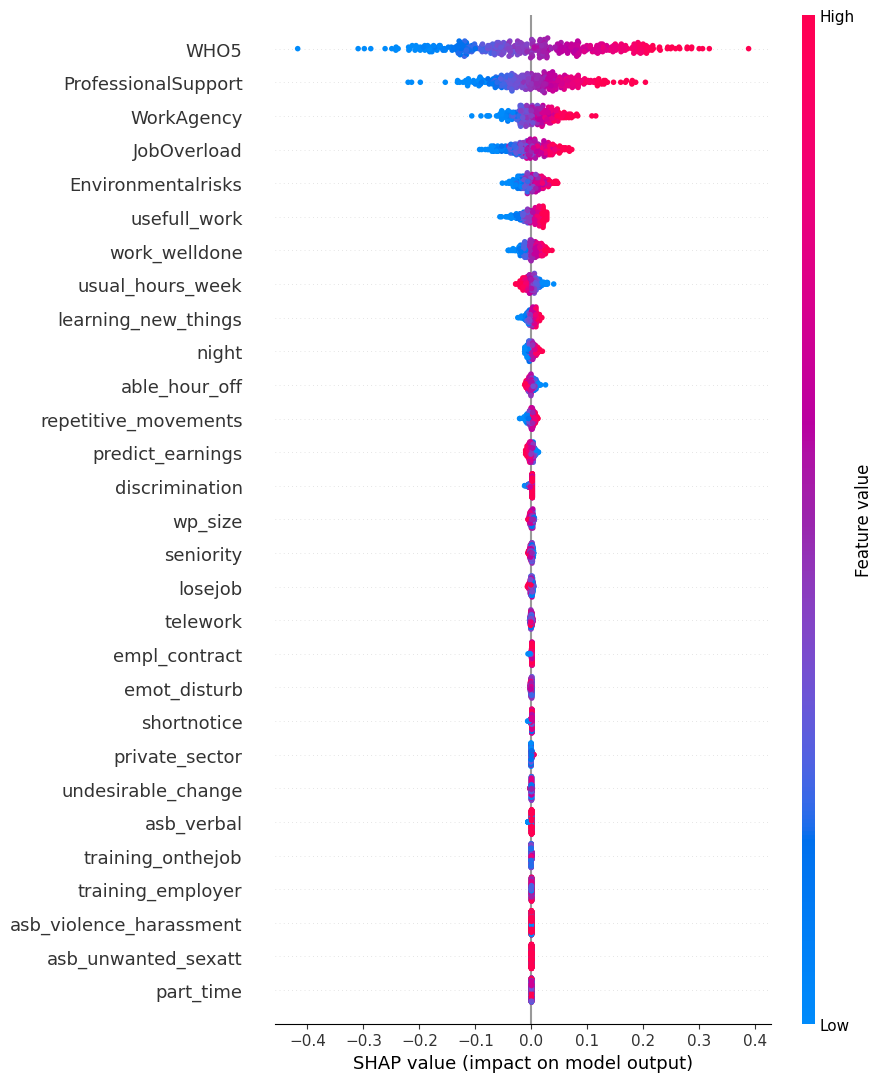

In [ ]:
shap.plots.beeswarm(shap_values_list_ElasticNet, max_display=30)

In [ ]:
#shap.waterfall_plot(shap_values_list_ElasticNet[2])


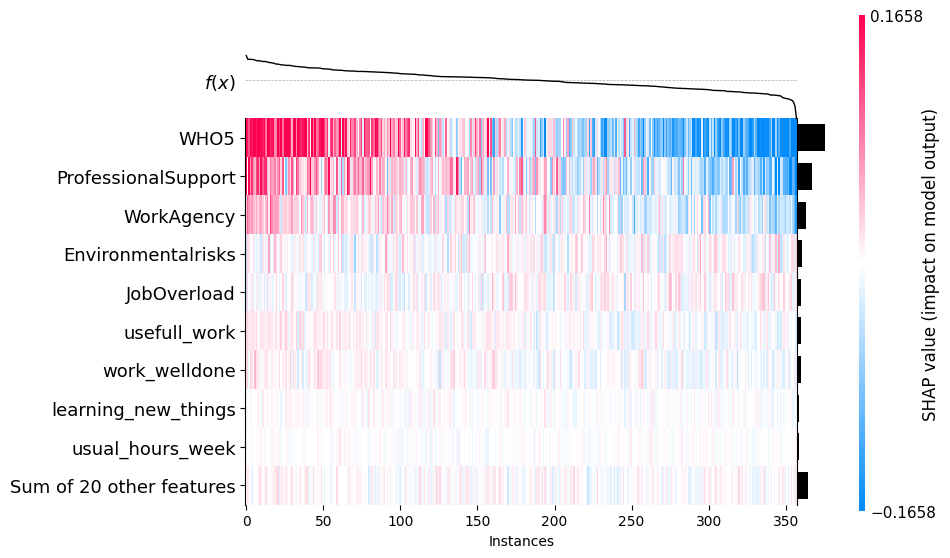

In [ ]:
shap.plots.heatmap(shap_values_list_xgb, instance_order=shap_values_list_xgb.sum(1))

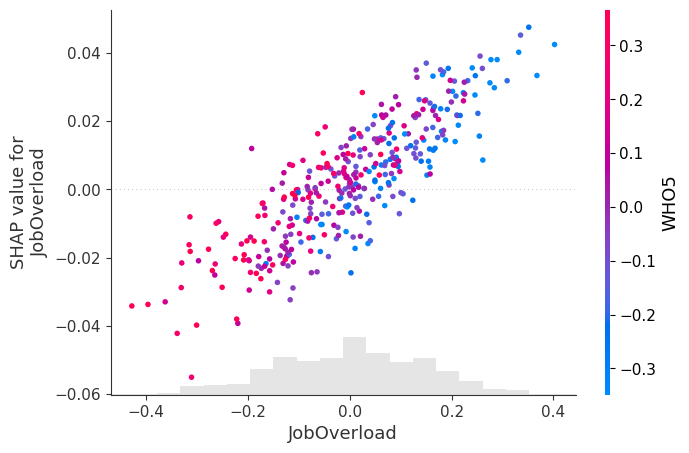

In [ ]:
shap.plots.scatter(shap_values_list_xgb[:, "JobOverload"],color=shap_values_list_xgb[:, "WHO5"])
#color=plt.get_cmap("cool")
#color=shap_values[:,"Workclass"])
